In [3]:
!pip install torch_geometric torch


  Using cached torch-2.2.2-cp311-none-macosx_10_9_x86_64.whl.metadata (25 kB)
  Using cached filelock-3.15.4-py3-none-any.whl.metadata (2.9 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached torch-2.2.2-cp311-none-macosx_10_9_x86_64.whl (150.8 MB)
Using cached filelock-3.15.4-py3-none-any.whl (16 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 17.9 MB/s eta 0:00:00a 0:00:01
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)


In [2]:
import pandas as pd
from datetime import datetime
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GATConv
from torch_geometric.data import HeteroData
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.nn import HeteroConv, GCNConv, SAGEConv, GATConv, Linear
import torch_geometric.transforms as T
from sklearn.preprocessing import StandardScaler

In [5]:
# Load the HeteroData object from the file
loaded_data = torch.load('hetero_data_final.pt')

In [6]:
loaded_data

HeteroData(
  y=[11771],
  user={ x=[35954, 2] },
  destination={ x=[5477, 3] },
  hotel={ x=[11771, 6] },
  city={ x=[6919, 2] },
  country={ x=[174, 2] },
  region={ x=[665, 2] },
  channel={ x=[11, 2] },
  (user, has_searched, destination)={
    edge_index=[2, 37349],
    edge_attr=[37349, 5],
  },
  (user, has_booked, hotel)={
    edge_index=[2, 37571],
    edge_attr=[37571, 10],
  },
  (destination, has_hotel, hotel)={
    edge_index=[2, 18262],
    edge_attr=[18262, 0],
  }
)

In [7]:
loaded_data.y

tensor([0.0000, 0.2000, 0.0000,  ..., 0.0000, 0.0000, 0.0000])

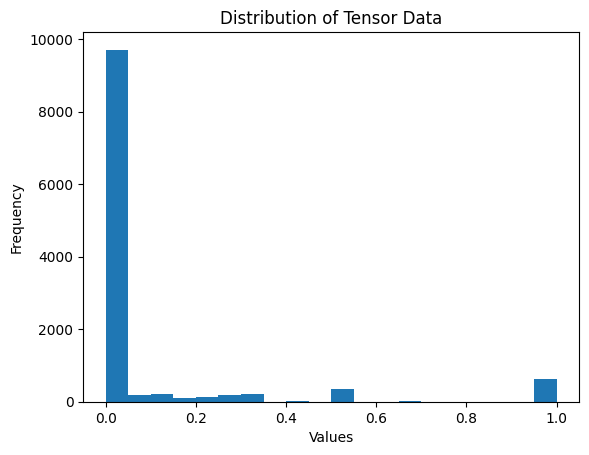

In [8]:
import matplotlib.pyplot as plt

# Assuming your tensor is named 'tensor_data'
tensor_data = loaded_data.y

# Convert the tensor to a numpy array for plotting
data_array = tensor_data.numpy()

# Plot the distribution
plt.hist(data_array, bins=20)  # Adjust the number of bins as per your preference
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of Tensor Data')
plt.show()


In [9]:
transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=2.0,
    add_negative_train_samples=False,
    edge_types=[("user", "has_searched", "destination"),("destination","has_hotel","hotel")],

)
train_data, val_data, test_data = transform(loaded_data)

In [10]:
train_data

HeteroData(
  y=[11771],
  user={ x=[35954, 2] },
  destination={ x=[5477, 3] },
  hotel={ x=[11771, 6] },
  city={ x=[6919, 2] },
  country={ x=[174, 2] },
  region={ x=[665, 2] },
  channel={ x=[11, 2] },
  (user, has_searched, destination)={
    edge_index=[2, 20917],
    edge_attr=[20917, 5],
    edge_label=[8964],
    edge_label_index=[2, 8964],
  },
  (user, has_booked, hotel)={
    edge_index=[2, 37571],
    edge_attr=[37571, 10],
  },
  (destination, has_hotel, hotel)={
    edge_index=[2, 10227],
    edge_attr=[10227, 0],
    edge_label=[4383],
    edge_label_index=[2, 4383],
  }
)

In [11]:
val_data

HeteroData(
  y=[11771],
  user={ x=[35954, 2] },
  destination={ x=[5477, 3] },
  hotel={ x=[11771, 6] },
  city={ x=[6919, 2] },
  country={ x=[174, 2] },
  region={ x=[665, 2] },
  channel={ x=[11, 2] },
  (user, has_searched, destination)={
    edge_index=[2, 29881],
    edge_attr=[29881, 5],
    edge_label=[11202],
    edge_label_index=[2, 11202],
  },
  (user, has_booked, hotel)={
    edge_index=[2, 37571],
    edge_attr=[37571, 10],
  },
  (destination, has_hotel, hotel)={
    edge_index=[2, 14610],
    edge_attr=[14610, 0],
    edge_label=[5478],
    edge_label_index=[2, 5478],
  }
)

In [12]:
data=loaded_data

In [13]:
data['hotel']

{'x': tensor([[    0,     4,  1241,    50,     2,    15],
        [ 2072,    72,  1241,    50,     2,    15],
        [ 3037,    39,  1241,    50,     2,    15],
        ...,
        [37522,    29,  1013,   144,     6,     4],
        [37558,    82,   797,   126,     3,    15],
        [37598,    50,   435,    50,     2,    25]])}

In [14]:
data.metadata()

(['user', 'destination', 'hotel', 'city', 'country', 'region', 'channel'],
 [('user', 'has_searched', 'destination'),
  ('user', 'has_booked', 'hotel'),
  ('destination', 'has_hotel', 'hotel')])

In [15]:
node_types, edge_types = data.metadata()
print(node_types)
print(edge_types)

['user', 'destination', 'hotel', 'city', 'country', 'region', 'channel']
[('user', 'has_searched', 'destination'), ('user', 'has_booked', 'hotel'), ('destination', 'has_hotel', 'hotel')]


In [16]:
num_nodes = data.num_nodes
num_nodes

60971

In [17]:
data.x_dict['hotel'].shape

torch.Size([11771, 6])

In [18]:
import torch

class GNNModel(nn.Module):
    def __init__(self, hidden_dim,num_layers):
        super(GNNModel, self).__init__()
        self.conv = torch.nn.ModuleList()

        for _ in range(num_layers):
            conv = HeteroConv({
                ('user', 'has_searched', 'destination'): GATConv((-1, -1), hidden_dim, add_self_loops=False),
                ('destination', 'has_hotel', 'hotel'): SAGEConv((-1, -1), hidden_dim, add_self_loops=False),
                # ('user', 'has_booked', 'hotel'): SAGEConv((-1, -1), hidden_dim, add_self_loops=False),
            }, aggr='sum')
            self.conv.append(conv)

    def forward(self, data):
        for conv in self.conv:
          # Convert node features to the appropriate data type
          x_dict = {key: value.to(torch.float32) for key, value in data.x_dict.items()}
          # Convert edge indices to the appropriate data type
          edge_index_dict = {key: value.to(torch.long) for key, value in data.edge_index_dict.items()}
          # print(x_dict['hotel'].shape)

          x_dict = conv(x_dict, edge_index_dict)
        return x_dict['hotel']


In [19]:
def compute_personalized_ranking(hotel_representations, y):
    # Sort the hotels based on the y values
    sorted_indices = torch.argsort(y, descending=True)
    personalized_ranking = hotel_representations[sorted_indices]
    return personalized_ranking


In [20]:
# Step 4: Define Recommendation Head
class RecommendationHead(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(RecommendationHead, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.fc(x)


In [21]:
output_dim=1

In [22]:
num_epochs=100

In [23]:
from torch_geometric.nn import GATConv, Linear, to_hetero
import torch.nn.functional as F
from torch.utils.data import DataLoader


In [ ]:
# Step 5: Training and Evaluation

# Define the GNN model and recommendation head
hidden_dim = 8
gnn_model = GNNModel(hidden_dim,8)
recommendation_head = RecommendationHead(hidden_dim, output_dim)

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(list(gnn_model.parameters()) + list(recommendation_head.parameters()), lr=0.01)

# Training loop
for epoch in range(num_epochs):
    gnn_model.train()
    recommendation_head.train()
    optimizer.zero_grad()

    # Forward pass
    node_representations = gnn_model(train_data)
    # predictions = compute_personalized_ranking(node_representations, data.y)
    predictions = recommendation_head(node_representations)

    predictions = predictions.squeeze()

    max_value = torch.max(predictions)
    min_value = torch.min(predictions)
    predictions = (predictions - min_value) / (max_value - min_value)


    # Compute loss
    train_data.y=train_data.y.long()
    loss = loss_fn(predictions, train_data.y.float())
    print(loss)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Validation
    gnn_model.eval()
    recommendation_head.eval()

    with torch.no_grad():
        node_representations_val = gnn_model(val_data)
        val_predictions = recommendation_head(node_representations_val)
        val_predictions = val_predictions.squeeze()
        val_max_value = torch.max(val_predictions)
        val_min_value = torch.min(val_predictions)
        val_predictions = (val_predictions - val_min_value) / (val_max_value - val_min_value)
        val_data.y=val_data.y.long()
        val_loss = loss_fn(val_predictions, val_data.y.float())

/usr/local/lib/python3.10/dist-packages/torch_geometric/nn/conv/hetero_conv.py:62: UserWarning: There exist node types ({'user'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behavior.
  warnings.warn(


tensor(0.4919, grad_fn=<MseLossBackward0>)
tensor(0.4542, grad_fn=<MseLossBackward0>)
tensor(0.4137, grad_fn=<MseLossBackward0>)
tensor(0.3706, grad_fn=<MseLossBackward0>)
tensor(0.3253, grad_fn=<MseLossBackward0>)
tensor(0.2791, grad_fn=<MseLossBackward0>)
tensor(0.2350, grad_fn=<MseLossBackward0>)
tensor(0.1942, grad_fn=<MseLossBackward0>)
tensor(0.1577, grad_fn=<MseLossBackward0>)
tensor(0.1357, grad_fn=<MseLossBackward0>)
tensor(0.1214, grad_fn=<MseLossBackward0>)
tensor(0.1114, grad_fn=<MseLossBackward0>)
tensor(0.1041, grad_fn=<MseLossBackward0>)
tensor(0.0985, grad_fn=<MseLossBackward0>)
tensor(0.0941, grad_fn=<MseLossBackward0>)
tensor(0.0906, grad_fn=<MseLossBackward0>)
tensor(0.0877, grad_fn=<MseLossBackward0>)
tensor(0.0852, grad_fn=<MseLossBackward0>)
tensor(0.0832, grad_fn=<MseLossBackward0>)
tensor(0.0814, grad_fn=<MseLossBackward0>)
tensor(0.0798, grad_fn=<MseLossBackward0>)
tensor(0.0784, grad_fn=<MseLossBackward0>)
tensor(0.0772, grad_fn=<MseLossBackward0>)
tensor(0.07